<a href="https://colab.research.google.com/github/zzaebok/2019-Computer-Vision/blob/master/project/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import os
import copy
import time
import tqdm
from datetime import timedelta
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# consistent result
random.seed(999)
np.random.seed(999)
torch.manual_seed(999)
torch.cuda.manual_seed(999)

In [0]:
# dataset class
class RealFakeDataset(Dataset):
  def __init__(self, img_list, path, kind, mode, transform = None):
    assert mode in ['train', 'val', 'test']
    
    label_dict = {'real':1, 'additional_real':1, 'fake':0, 'gan':0}
    self.img_list = img_list
    self.path = path
    self.kind = kind
    self.mode = mode
    self.transform = transform
    if self.mode == 'train' or self.mode == 'val':
      self.label = label_dict[kind]
      
  def __len__(self):
    return len(self.img_list)
  
  def __getitem__(self, idx):
    if self.mode == 'train' or self.mode == 'val':
      img = Image.open(os.path.join(self.path, self.kind, self.img_list[idx]))
    else:
      img = Image.open(os.path.join(self.path, self.img_list[idx]))
      
    if self.transform:
      img = self.transform(img)
      
    if self.mode == 'train' or self.mode == 'val':
      return img, self.label
    # test
    else:
      return img, self.img_list[idx]

In [0]:
################# train_path ###################
train_path = '/content/drive/My Drive/Colab Notebooks/vision/trainset'
################################################

#data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(18),
    transforms.ColorJitter(0.2),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

kinds = ['additional_real', 'real','fake','gan']

In [0]:
# stratified kfolds / not using StratifiedKFold()
imgs = [os.listdir(os.path.join(train_path, kind)) for kind in kinds]

k = 10
cv = KFold(k, shuffle = True)
train_folds = {'additional_real':[], 'real':[], 'fake':[], 'gan':[]}
val_folds = {'additional_real':[], 'real':[], 'fake':[], 'gan':[]}

for i, img_list in enumerate(imgs):
  for train, val in cv.split(img_list):
    # train, val are indices
    train_folds[kinds[i]].append([img_list[idx] for idx in train])
    val_folds[kinds[i]].append([img_list[idx] for idx in val])
    
# make datasets for train and validation
train_datasets = []
val_datasets = []
for i in range(k):
  train_datasets.append(ConcatDataset([RealFakeDataset(train_fold[i], train_path, kind, mode='train', transform=train_transform) for kind, train_fold in train_folds.items()]))
  val_datasets.append(ConcatDataset([RealFakeDataset(val_fold[i], train_path, kind, mode='val', transform=val_transform) for kind, val_fold in val_folds.items()]))

tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1])


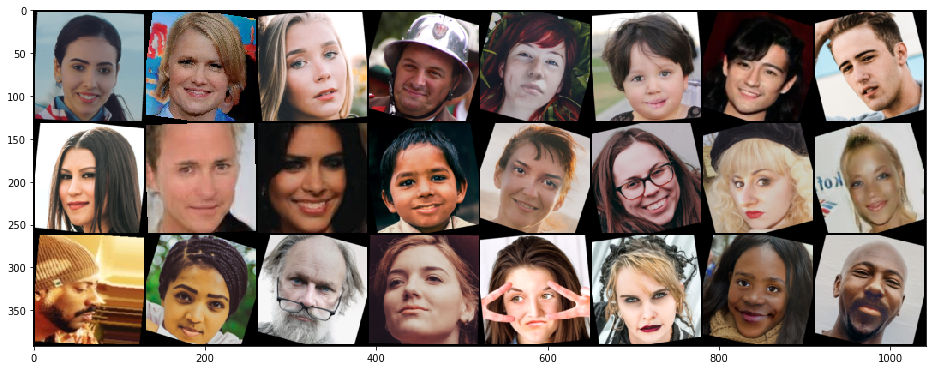

In [0]:
# quick check for data loader
train_loader = DataLoader(train_datasets[0], batch_size=32, shuffle=True, num_workers=4)
samples, labels = iter(train_loader).next()
print(labels)
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [0]:
# function which calculates accuracy / only in training
def accuracy(output, labels):
  pred = torch.argmax(output, dim=1)
  correct = pred.eq(labels)
  return torch.mean(correct.float())

In [0]:
# drawing graph
def draw_graph(k, loss_list, score_list):
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(loss_list, label='loss', color = 'g')
  ax2.plot(score_list, label='score', color = 'b')

  ax1.set_ylabel('loss')
  ax2.set_ylabel('score')
  
  plt.title('{} Fold - training loss and score'.format(k))
  plt.show()

In [0]:
# 재복
# Simple average ensemble model with resnet and densenet
class ResDense(nn.Module):
    def __init__(self, device):
        super(ResDense, self).__init__()
        self.device = device
        # Resnet + Densenet
        self.resnet = torchvision.models.resnet50(pretrained=True).to(device)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)
        
        self.densenet = torchvision.models.densenet169(pretrained=True).to(device)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, 2)
        
        self.classifier = nn.Linear(4,2)
        
    def forward(self, x):
        # combine
        output = torch.cat((self.resnet(x), self.densenet(x)), dim=1)
        output = self.classifier(F.relu(output))
        return output
      
    
    def _train(self, train_loader, val_loader, optimizer, scheduler, loss_fn):
      
      '''
      #if you wanna see the training process...
      itr = 1
      p_itr = 50
      total_loss = 0
      total_acc = 0
      '''
      self.train()
      for samples, labels in train_loader:
        samples, labels = samples.to(self.device), labels.to(self.device)    
        optimizer.zero_grad()
        output = self(samples)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
          
        '''
        total_loss += loss.item()
        total_acc += accuracy(output, labels)
          
        if itr%p_itr==0:
            print('Train Loss: {:.4f}, Accuracy: {:.3f}'.format(total_loss/p_itr, total_acc/p_itr))
            total_loss, total_acc = 0,0
        itr += 1
        '''
        
      val_score = self.__eval(val_loader)
      return val_score
    
    
    def __eval(self, val_loader):
      self.eval()
      val_outputs = []
      val_labels = []
      for samples, labels in val_loader:
        samples, labels = samples.to(self.device), labels.to(self.device)
        with torch.no_grad():
          output = F.softmax(self(samples),dim =1)
          val_outputs.extend(output[:,1].cpu().tolist())
          val_labels.extend(labels.cpu().tolist())
      val_score = roc_auc_score(val_labels, val_outputs)
      return val_score
        

In [0]:
# 한모
class Resnet(nn.Module):
    def __init__(self, device):
        super(Resnet, self).__init__()
        self.device = device
        self.resnet = torchvision.models.resnet50(pretrained=True).to(device)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)
        
    def forward(self, x):
        # just forward
        output = self.resnet(x)
        return output
      
    
    def _train(self, train_loader, val_loader, optimizer, scheduler, loss_fn):
      
      self.train()
      for samples, labels in train_loader:
        samples, labels = samples.to(self.device), labels.to(self.device)    
        optimizer.zero_grad()
        output = self(samples)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
      val_score = self.__eval(val_loader)
      return val_score
    
    
    def __eval(self, val_loader):
      self.eval()
      val_outputs = []
      val_labels = []
      for samples, labels in val_loader:
        samples, labels = samples.to(self.device), labels.to(self.device)
        with torch.no_grad():
          output = F.softmax(self(samples),dim =1)
          val_outputs.extend(output[:,1].cpu().tolist())
          val_labels.extend(labels.cpu().tolist())
      val_score = roc_auc_score(val_labels, val_outputs)
      return val_score
        

In [0]:
# 지수
class Densenet(nn.Module):
    def __init__(self, device):
        super(Densenet, self).__init__()
        self.device = device
        self.densenet = torchvision.models.densenet169(pretrained=True).to(device)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, 2)
        
    def forward(self, x):
        # forward
        output = self.densenet(x)
        return output
      
    
    def _train(self, train_loader, val_loader, optimizer, scheduler, loss_fn):
      self.train()
      for samples, labels in train_loader:
        samples, labels = samples.to(self.device), labels.to(self.device)    
        optimizer.zero_grad()
        output = self(samples)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
      val_score = self.__eval(val_loader)
      return val_score
    
    
    def __eval(self, val_loader):
      self.eval()
      val_outputs = []
      val_labels = []
      for samples, labels in val_loader:
        samples, labels = samples.to(self.device), labels.to(self.device)
        with torch.no_grad():
          output = F.softmax(self(samples),dim =1)
          val_outputs.extend(output[:,1].cpu().tolist())
          val_labels.extend(labels.cpu().tolist())
      val_score = roc_auc_score(val_labels, val_outputs)
      return val_score
        

In [0]:
# transfer learning, loss function, optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 0.00025
batch_size = 32
criterion = nn.CrossEntropyLoss()

###KFold Cross Validation executed

|Model|Average Validation Score|
|:--------|:--------:|
|  ResNet50 | 0.9430705 |
|  DenseNet169 | 0.9395098 |
|  ResDense | 0.9346007 |



===Epoch 1===
* Fold 0 validation score: 0.8309183
* Fold 1 validation score: 0.8354145
* Fold 2 validation score: 0.7914210
* Fold 3 validation score: 0.8276083
* Fold 4 validation score: 0.6754141
* Fold 5 validation score: 0.8328974
* Fold 6 validation score: 0.8731037
* Fold 7 validation score: 0.8644289
* Fold 8 validation score: 0.8941006
* Fold 9 validation score: 0.8581517
[Epoch 1/20] Average validation score: 0.8283459 ---

===Epoch 2===
* Fold 0 validation score: 0.8292220
* Fold 1 validation score: 0.8621806
* Fold 2 validation score: 0.8359348
* Fold 3 validation score: 0.8759082
* Fold 4 validation score: 0.7865155
* Fold 5 validation score: 0.8407004
* Fold 6 validation score: 0.8630776
* Fold 7 validation score: 0.8827376
* Fold 8 validation score: 0.9101133
* Fold 9 validation score: 0.8767945
[Epoch 2/20] Average validation score: 0.8563185 ---

===Epoch 3===
* Fold 0 validation score: 0.8545225
* Fold 1 validation score: 0.9117962
* Fold 2 validation score: 0.8793936

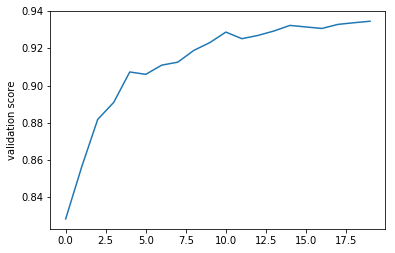

Training took: 2:45:14 secs (Wall clock time)


In [0]:
# Kfold cross validation
start_time = time.time()

epochs = 20
# Prepare each fold's data

train_loaders = [DataLoader(train_datasets[i], batch_size=batch_size, shuffle=True, num_workers=4) for i in range(k)] 
val_loaders = [DataLoader(val_datasets[i], batch_size=batch_size, shuffle=False, num_workers=4) for i in range(k)]
###############################
surrogate_models = [ResDense(device).to(device) for _ in range(k)]
#surrogate_models = [Resnet(device).to(device) for _ in range(k)]
#surrogate_models = [Densenet(device).to(device) for _ in range(k)]
###############################
optimizers = [torch.optim.Adam(surrogate_model.parameters(), lr=learning_rate, amsgrad=True) for surrogate_model in surrogate_models]
schedulers = [torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5) for optimizer in optimizers]


best_val_score = 0
cv_scores = []
for epoch in range(epochs):
  print('===Epoch {}==='.format(epoch+1))
  val_scores = []
  # k fold
  for i in range(k):
    val_score = surrogate_models[i]._train(train_loaders[i], val_loaders[i], optimizers[i], schedulers[i], criterion)
    val_scores.append(val_score)
    print('* Fold {} validation score: {:.7f}'.format(i, val_score))
  avg_val_score = sum(val_scores)/len(val_scores)    
  print('[Epoch {}/{}] Average validation score: {:.7f} ---'.format(epoch+1,epochs,avg_val_score))
  print()
  cv_scores.append(avg_val_score)
  # update new best score
  if avg_val_score > best_val_score:
    best_val_score = avg_val_score
  

print('Best Validation Score: {:.7f}'.format(best_val_score))

plt.plot(cv_scores)
plt.ylabel('validation score')
plt.show()
      
elapsed_time_secs = time.time() - start_time
msg = "Training took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg)

### Final Model Training (without resampling)
1. Holdout set(validation set) is only extracted from given data ( not with oversampled data).
2. Real: Fake: Gan = 60: 30: 30

These are results
- ResNet: 0.9245902
- DenseNet: 0.9338798
- ResDense: 0.9491803

-----------------------------
### Final Model Training (with resampling)
1. Fake and Gan images are doubled (resampled)
2. Real: Fake: Gan = 60: 30: 30

These are results
- ResNet: 0.9256831
- DenseNet: 0.9306011
- ResDense: 0.9188525

In [0]:
################# train_path ###################
train_path = '/content/drive/My Drive/Colab Notebooks/vision/trainset'
################################################

#data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(18),
    transforms.ColorJitter(0.2),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

kinds = ['additional_real', 'real','fake','gan']

In [0]:
# Final model training / holdout => real: 60 / fake: 30 / gan: 30
reals = sorted(os.listdir(os.path.join(train_path, 'real')))
fakes = sorted(os.listdir(os.path.join(train_path, 'fake')))
gans = sorted(os.listdir(os.path.join(train_path, 'gan')))
holdout = {'additional_real':[], 'real':reals[::len(reals)//60], 'fake':fakes[::len(fakes)//30], 'gan': gans[::len(gans)//30]}

train_dataset = ConcatDataset([RealFakeDataset([fn for fn in os.listdir(os.path.join(train_path,kind)) if fn not in holdout[kind]], train_path, kind, mode='train', transform=train_transform) for kind in kinds])
holdout_dataset = ConcatDataset([RealFakeDataset(holdout[kind], train_path, kind, mode='val', transform=val_transform) for kind in kinds])

'''
#training with resample on fake images (real+additional : 3720 / fake+gan doubled: 3720)
reals = sorted(os.listdir(os.path.join(train_path, 'real')))
fakes = sorted(os.listdir(os.path.join(train_path, 'fake')))
gans = sorted(os.listdir(os.path.join(train_path, 'gan')))
holdout = {'additional_real':[], 'real':reals[::len(reals)//60], 'fake':fakes[::len(fakes)//30], 'gan': gans[::len(gans)//30]}
tmp_list = []
for kind in kinds:
  if kind == 'gan' or kind == 'fake':
    fl = [fn for fn in os.listdir(os.path.join(train_path,kind)) if fn not in holdout[kind]]*2
  else:
    fl = [fn for fn in os.listdir(os.path.join(train_path,kind)) if fn not in holdout[kind]]
  tmp_list.append(RealFakeDataset(fl, train_path, kind, mode='train', transform=train_transform))
train_dataset = ConcatDataset(tmp_list)
holdout_dataset = ConcatDataset([RealFakeDataset(holdout[kind], train_path, kind, mode='val', transform=val_transform) for kind in kinds])
'''

"\n#training with resample on fake images (real+additional : 3720 / fake+gan doubled: 3720)\nreals = sorted(os.listdir(os.path.join(train_path, 'real')))\nfakes = sorted(os.listdir(os.path.join(train_path, 'fake')))\ngans = sorted(os.listdir(os.path.join(train_path, 'gan')))\nholdout = {'additional_real':[], 'real':reals[::len(reals)//60], 'fake':fakes[::len(fakes)//30], 'gan': gans[::len(gans)//30]}\ntmp_list = []\nfor kind in kinds:\n  if kind == 'gan' or kind == 'fake':\n    fl = [fn for fn in os.listdir(os.path.join(train_path,kind)) if fn not in holdout[kind]]*2\n  else:\n    fl = [fn for fn in os.listdir(os.path.join(train_path,kind)) if fn not in holdout[kind]]\n  tmp_list.append(RealFakeDataset(fl, train_path, kind, mode='train', transform=train_transform))\ntrain_dataset = ConcatDataset(tmp_list)\nholdout_dataset = ConcatDataset([RealFakeDataset(holdout[kind], train_path, kind, mode='val', transform=val_transform) for kind in kinds])\n"

[Epoch 1/30] Validation Score: 0.9240437 ---
[Epoch 2/30] Validation Score: 0.9114754 ---
[Epoch 3/30] Validation Score: 0.8969945 ---
[Epoch 4/30] Validation Score: 0.8767760 ---
[Epoch 5/30] Validation Score: 0.8939891 ---
[Epoch 6/30] Validation Score: 0.8980874 ---
[Epoch 7/30] Validation Score: 0.9013661 ---
[Epoch 8/30] Validation Score: 0.8887978 ---
[Epoch 9/30] Validation Score: 0.9204918 ---
[Epoch 10/30] Validation Score: 0.9270492 ---
[Epoch 11/30] Validation Score: 0.9314208 ---
[Epoch 12/30] Validation Score: 0.9251366 ---
[Epoch 13/30] Validation Score: 0.9269126 ---
[Epoch 14/30] Validation Score: 0.9262295 ---
[Epoch 15/30] Validation Score: 0.9251366 ---
[Epoch 16/30] Validation Score: 0.9221311 ---
[Epoch 17/30] Validation Score: 0.9297814 ---
[Epoch 18/30] Validation Score: 0.9327869 ---
[Epoch 19/30] Validation Score: 0.9245902 ---
[Epoch 20/30] Validation Score: 0.9308743 ---
[Epoch 21/30] Validation Score: 0.9349727 ---
[Epoch 22/30] Validation Score: 0.9303279 -

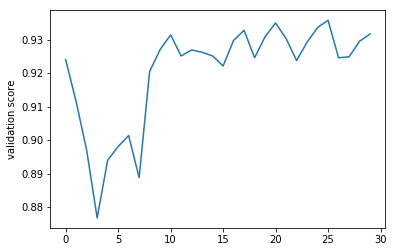

Training took: 0:33:03 secs (Wall clock time)


In [0]:
# training final model without resample  (additional = 773)
start_time = time.time()

epochs = 30

##############바꾸세요################
model = ResDense(device).to(device)
#model = Resnet(device).to(device)
#model = Densenet(device).to(device)
save_path = '/content/drive/My Drive/Colab Notebooks/vision/ResDense.pth'
######################################


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00025, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

best_val_score = 0
val_scores = []
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(epochs):
  val_score = model._train(train_loader, holdout_loader, optimizer, scheduler, criterion)
  val_scores.append(val_score)
  print('[Epoch {}/{}] Validation Score: {:.7f} ---'.format(epoch+1,epochs,val_score))
  
  # update new best score
  if val_score > best_val_score:
    best_val_score = val_score
    best_model_wts = copy.deepcopy(model.state_dict())
  
print('Training Finished... Best Validation Score: {:.7f}'.format(best_val_score))

plt.plot(val_scores)
plt.ylabel('validation score')
plt.show()
      
elapsed_time_secs = time.time() - start_time
msg = "Training took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg)


torch.save(best_model_wts, save_path)

###KFold Aggregation
1. Make a model per each fold (we used k = 10)
2. Each models is trained per fold
3. When making prediction, we aggregate k models together

Average of each folds' validation score ( it doesn't mean average score of whole model)
- ResNet34: 0.9324
- ResNet50: 0.9460
- ResNet152: 0.9421
- DenseNet121: 0.9347
- DenseNet169: 0.9427

In [0]:
# KFold aggregation (Kagging)
class Kmodels(nn.Module):
    def __init__(self, num, device):
        super(Kmodels,self).__init__()
        # you should use nn.ModuleList. Optimizer doesn't detect python list as parameters
        self.models = nn.ModuleList()
        for _ in range(num):
          model = torchvision.models.resnet34(pretrained=True).to(device)
          #model = torchvision.models.densenet169(pretrained=True).to(device)
          
          num_ftrs = model.fc.in_features
          model.fc = nn.Linear(num_ftrs, 2)
          nn.init.xavier_normal_(model.fc.weight)
          self.models.append(model)
          ''' for densenet
          num_ftrs = model.classifier.in_features
          model.classifier = nn.Linear(num_ftrs, 2)
          nn.init.xavier_normal_(model.classifier.weight)
          self.models.append(model)
          '''
          
    def forward(self, x):
        # each models outputs scores / kmodels outputs softmax score
        output = torch.zeros([x.size(0), 2]).to(device)
        for model in self.models:
            output += model(x)
        return output

In [0]:
# transfer learning, loss function, optimizer
k = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kmodels = Kmodels(k, device).to(device)
criterion = nn.CrossEntropyLoss()

In [0]:
start_time = time.time()

epochs = 20
p_itr = 30
best_scores = []

# k fold
for i in range(k):
  itr = 1
  total_loss, score = 0,0
  val_score = 0.0
  val_acc = 0.0
  best_score = 0.0
  loss_list = []
  score_list = []
  train_loader = DataLoader(train_datasets[i], batch_size=32, shuffle=True, num_workers=4)
  val_loader = DataLoader(val_datasets[i], batch_size=32, shuffle=False, num_workers=4)
  model = kmodels.models[i]
  optimizer = torch.optim.Adam(model.parameters(), lr=0.00025, amsgrad=True)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)
  best_model_wts = copy.deepcopy(model.state_dict())
  for epoch in range(epochs):
    model.train()
    for samples, labels in train_loader:
        samples, labels = samples.to(device), labels.to(device)    
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        score += accuracy(output, labels)
        scheduler.step()
        
        if itr%p_itr==0:
            # print('[Fold {}/{}] [Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(i+1, k, epoch+1, epochs, itr, total_loss/p_itr, score/p_itr))
            loss_list.append(total_loss/p_itr)
            score_list.append(score/p_itr)
            total_loss, score = 0,0
        itr += 1
        
    # use validation set for finding well updated weights
    val_outputs = []
    val_labels = []
    model.eval()
    for samples, labels in val_loader:
        with torch.no_grad():
            samples, labels = samples.to(device), labels.to(device)
            output = nn.functional.softmax(model(samples),dim =1)
            # probability of real
            val_outputs.extend(output[:,1].cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
            val_acc += accuracy(output, labels)
    val_score = roc_auc_score(val_labels, val_outputs)
    print('[Fold {}/{}] [Epoch {}/{}] Validation Score: {:.4f}, Validation Accuracy: {:.4f}'.format(i+1, k, epoch+1, epochs, val_score, val_acc/len(val_loader)))
    if val_score > best_score:
        best_score = val_score
        best_model_wts = copy.deepcopy(model.state_dict())
    val_score = 0
    val_acc = 0
  print('--- [Fold {}/{}] Best score: {:.4f} ---'.format(i+1, k, best_score))
  best_scores.append(best_score)
  draw_graph(i, loss_list, score_list)
  
  # store best performed weights on each models
  kmodels.models[i].load_state_dict(best_model_wts)
  
print('Average Validation Score: {:.4f}'.format(sum(best_scores)/len(best_scores)))
      
elapsed_time_secs = time.time() - start_time
msg = "Training took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg)      
  
# store the whole model  
save_path = '/content/drive/My Drive/Colab Notebooks/vision/ckpt_resnet34_k10_e20_balanced_score{:.4f}.pth'.format(sum(best_scores)/len(best_scores))
torch.save(kmodels.state_dict(), save_path)

In [0]:
####################TEST#####################

############ 바꾸세요 ################
load_path = '/content/drive/My Drive/Colab Notebooks/vision/ResDense.pth'
txt_save_path = '/content/drive/My Drive/Colab Notebooks/vision/ResDense.txt'
test_path = '/content/drive/My Drive/Colab Notebooks/vision/test'

test_model = ResDense(device).to(device)
#test_model = Resnet(device).to(device)
#test_model = Densenet(device).to(device)
#test_model = Kmodels(10, device).to(device)
######################################

test_model.load_state_dict(torch.load(load_path))


test_transform = transforms.Compose([
    # test images are already 128x128 size
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

#load test dataset
test_files = os.listdir(test_path)
test_dataset = RealFakeDataset(test_files, test_path, kind=None, mode='test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

test_model.eval()                               
test_outputs = []
test_names = []
for samples, names in tqdm.tqdm_notebook(test_loader):
  with torch.no_grad():
    samples = samples.to(device)
    test_outputs.extend(F.softmax(test_model(samples), dim=1)[:,1].cpu().tolist())
    test_names.extend(names)
        
test_result = {name:score for score, name in zip(test_outputs, test_names)}
test_result = {k: test_result[k] for k in sorted(test_result.keys())}

f = open(txt_save_path, 'w')
for k,v in test_result.items():
  f.write(k + ',{:.7f}'.format(v)+'\n')
f.close()

[(0, 0.9907835721969604, tensor(1, device='cuda:0')), (2, 0.9914835095405579, tensor(1, device='cuda:0')), (65, 0.013627120293676853, tensor(0, device='cuda:0')), (66, 0.12059634178876877, tensor(0, device='cuda:0')), (61, 0.8443264365196228, tensor(0, device='cuda:0')), (63, 0.99979168176651, tensor(0, device='cuda:0')), (1, 0.04087572544813156, tensor(1, device='cuda:0')), (15, 0.11904551088809967, tensor(1, device='cuda:0'))]


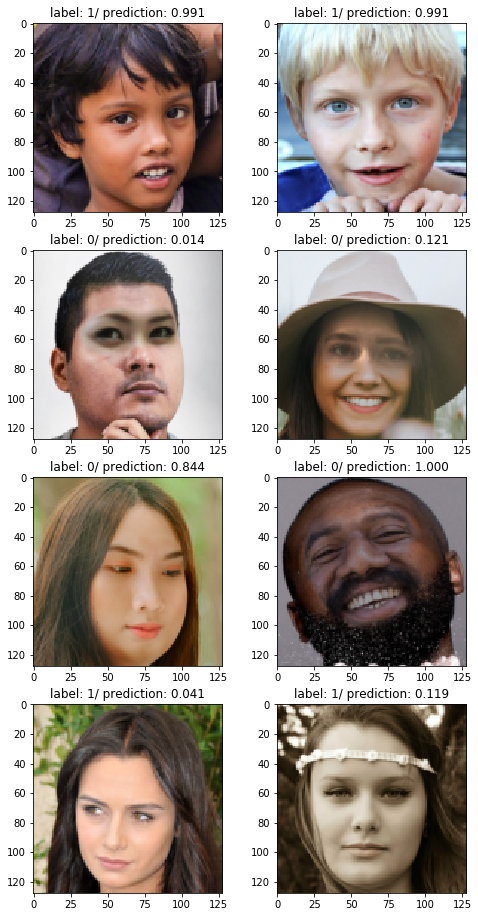

In [0]:
# sample classification results of our network ( ResDense )

load_path = '/content/drive/My Drive/Colab Notebooks/vision/ResDense_resample.pth'
model = ResDense(device).to(device)
model.load_state_dict(torch.load(load_path))

holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
model.eval()                               
test_outputs = []
test_labels = []
for samples, labels in holdout_loader:
  with torch.no_grad():
    samples, labels = samples.to(device), labels.to(device)
    test_outputs.extend(F.softmax(model(samples), dim=1)[:,1].cpu().tolist())
    test_labels.extend(labels)

tp = [(i,pred,label) for i, (pred, label) in enumerate(zip(test_outputs, test_labels)) if pred >= 0.8 and label == 1][:2]
tn = [(i,pred,label) for i, (pred, label) in enumerate(zip(test_outputs, test_labels)) if pred <= 0.2 and label == 0][:2]
fp = [(i,pred,label) for i, (pred, label) in enumerate(zip(test_outputs, test_labels)) if pred >= 0.8 and label == 0][:2]
fn = [(i,pred,label) for i, (pred, label) in enumerate(zip(test_outputs, test_labels)) if pred <= 0.2 and label == 1][:2]

t = tp + tn + fp + fn

w=2
h=2
fig=plt.figure(figsize=(8, 16))
columns = 2
rows = 4
for i in range(1, columns*rows+1):
    img = holdout_dataset[t[i-1][0]][0].permute(1,2,0).numpy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text("label: {}/ prediction: {:.3f}".format(t[i-1][2],t[i-1][1]))
    plt.imshow(img)
plt.show()